In [1]:
import os
import mne
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import ghostipy
from ghostipy.spectral.wavelets import MorseWavelet

import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from mne.time_frequency import morlet
from mne.time_frequency.tfr import cwt
from mne.time_frequency import tfr_morlet
from mne import create_info, EpochsArray
from mne.channels import make_dig_montage
from mne.preprocessing import ICA

from meegkit.asr import ASR

/home/rishab/miniconda3/envs/schizo/lib/python3.11/site-packages/mne/externals/tempita/__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


## Read the edf files containing EEG data

In [3]:
data_raw_file = './EEG_data'
raw_files_healthy = []
raw_files_schizo = []
file_list = os.listdir(data_raw_file)
for files in file_list:
    if files.endswith('.edf') and files.startswith('h'):
        file_path = os.path.join(data_raw_file,files)
        raw = mne.io.read_raw_edf(file_path,preload=True)
        raw_files_healthy.append(raw)
    
    elif files.endswith('.edf') and files.startswith('s'):
        file_path = os.path.join(data_raw_file,files)
        raw = mne.io.read_raw_edf(file_path,preload=True)
        raw_files_schizo.append(raw)

## Use morse wavelet to apply continous wavelet transforms on EEG time series

In [4]:
import meegkit.asr as asr

##------------------- check channel_data -----------------------------------

if not os.path.exists('image_dir'):
    os.makedirs('image_dir')

if not os.path.exists('image_dir/healthy'):
    os.makedirs('image_dir/healthy')

if not os.path.exists('image_dir/schizophrenic'):
    os.makedirs('image_dir/schizophrenic')


def The_Creation_of_the_wavelet(dir_path):
    sfreq = 250
    asr_instance = asr.ASR(method="euclid")
    gmw = MorseWavelet(gamma=2, beta=1)
    raw_files_healthy = []
    raw_files_schizo = []
    file_list = os.listdir(dir_path)
    
    for files in file_list:
        if files.endswith('.edf') and files.startswith('h'):
            file_path = os.path.join(dir_path,files)
            raw = mne.io.read_raw_edf(file_path,preload=True)
            raw_files_healthy.append(raw)
            data_healthy = raw._data
            train_idx = np.arange(0, 30 * sfreq, dtype=int)
            asr_data_healthy, _ = asr_instance.fit(data_healthy[:, train_idx])

            channels = raw.ch_names
            dict_eeg = {channels[i] : asr_data_healthy[i] for i in range(19)}
            
            i = 0
            for channel_name, channel_data in dict_eeg.items():
                Wxh, *_  = ghostipy.spectral.cwt(channel_data, wavelet=gmw, voices_per_octave=10)
                # Plot the time frequency map
                plt.imshow(np.abs(Wxh), aspect='auto', cmap='turbo')
                file_name=files.replace('.edf',' ')
                
                image_filename = channel_name + '_' + file_name + str(i) + '.png'
                image_path = os.path.join(f"./image_dir/healthy/", image_filename)
                plt.axis('off')
                plt.savefig(image_path)
                i = i + 1

        elif files.endswith('.edf') and files.startswith('s'):
            file_path = os.path.join(dir_path,files)
            raw = mne.io.read_raw_edf(file_path,preload=True)
            raw_files_schizo.append(raw)
            data_schizo = raw._data
            train_idx = np.arange(0, 30 * sfreq, dtype=int)
            asr_data_schizo, _ = asr_instance.fit(data_schizo[:, train_idx])
            channels = raw.ch_names
            dict_eeg = {channels[i] : asr_data_schizo[i] for i in range(19)}

            i = 0
            for channel_name, channel_data in dict_eeg.items():
                Wxs, *_  = ghostipy.spectral.cwt(channel_data, wavelet=gmw, voices_per_octave=10)
                # Plot the time frequency map
                plt.imshow(np.abs(Wxs), aspect='auto', cmap='turbo')
                file_name=files.replace('.edf',' ')
                
                image_filename = channel_name + '_' + file_name + str(i) + '.png'
                image_path = os.path.join(f"./image_dir/schizophrenic/", image_filename)
                plt.axis('off')
                plt.savefig(image_path)
                i = i + 1

In [5]:
# The_Creation_of_the_wavelet("./EEG_data")

In [3]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder("./image_dir", transform=preprocess)

# Define the sizes for the training and testing subsets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Use random_split to split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Build a Resnet-18 model and run Transfer learning on it using scalograms

In [23]:
class resnet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

        self.convolutional_layers = nn.Sequential(resnet.conv1,
                                   resnet.bn1,
                                   resnet.relu,
                                   resnet.maxpool,
                                   resnet.layer1,
                                   resnet.layer2,
                                   resnet.layer3,
                                   resnet.layer4)

        # # Add back the batch norm layer that we removed
        self.avgpool = resnet.avgpool # Global Average pooling layer

        # # # Custom fully connect layer
        self.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=num_classes) 

        # gradient placeholder
        self.gradient = None

    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.convolutional_layers(x)
    
    def forward(self, images):
        images.requires_grad = True
        
        # Convolutional layers of resnet18
        x = self.convolutional_layers(images) 
               
        # # The layers after the Conv you used the hook on
        h = x.register_hook(self.activations_hook)
        
        # Global average pooling layer from resnet18
        x = self.avgpool(x)
        
        x = x.reshape(x.size(0), -1)
        logits = self.fc(x)
        
        output = F.sigmoid(logits)
        return output

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 20
num_batches = len(train_dataloader) 
learning_rate = 1e-3

model = model = resnet(num_classes=1).to(device)

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCELoss()

Using cache found in /home/rishab/.cache/torch/hub/pytorch_vision_v0.10.0
/home/rishab/miniconda3/envs/schizo/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishab/miniconda3/envs/schizo/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training Loop 

In [5]:
running_loss = 0.

start_epoch = 1
step = 0
start_at_checkpoint = False 
checkpoint_path = "./model_checkpoints/"

writer = SummaryWriter("runs/resnet")


if(start_at_checkpoint):
    start_epoch = 201 # The start epoch of the model you want to load.
    step = start_epoch
    resume_epoch = start_epoch-1
    checkpoint = torch.load(f'{checkpoint_path}/resnet-finetune-adam-epoch_{resume_epoch}')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.train()
    
for epoch in range(num_epochs-start_epoch+1):
    for batch_num, (image_batch, label_batch) in enumerate(train_dataloader):
        image_batch = image_batch.to(device)        
        label_batch = label_batch.to(device)
        
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(image_batch)

        label_batch = label_batch.float()
        # Compute the loss and its gradients
        loss = loss_fn(outputs, label_batch.unsqueeze(1))
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        running_loss +=loss.item()
        
        # Update tqdm progress bar description
        # train_dataloader.set_postfix(epoch = epoch, loss = loss.item())

    # Gather data and report
    print('epoch {} loss: {}'.format(epoch+start_epoch, running_loss/num_batches))
    writer.add_scalar("Training loss Adam", running_loss/num_batches, global_step=step)
    step += 1
    running_loss = 0.0
    
    if (epoch+1)%5 == 0:
        checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(checkpoint, f'{checkpoint_path}/resnet-finetune-adam-epoch_{epoch+start_epoch}')


epoch 1 loss: 0.591249641444948
epoch 2 loss: 0.2988671329286363
epoch 3 loss: 0.12891187912060154
epoch 4 loss: 0.07827599098285039
epoch 5 loss: 0.08521862286660406
epoch 6 loss: 0.048255281031338706
epoch 7 loss: 0.07556265152783857
epoch 8 loss: 0.029432446799344487
epoch 9 loss: 0.02117941544080774
epoch 10 loss: 0.014307015730688969
epoch 11 loss: 0.08840193594288495
epoch 12 loss: 0.04924789549679392
epoch 13 loss: 0.0575333239717616
epoch 14 loss: 0.04475801661869304
epoch 15 loss: 0.018135413812059496
epoch 16 loss: 0.020902024620833497
epoch 17 loss: 0.040991650273402534
epoch 18 loss: 0.022649856413611107
epoch 19 loss: 0.010849516373127699
epoch 20 loss: 0.008762639766145084


## Inference Loop

In [8]:
total_correct = 0
total_samples = 0
model_num = 20
model_name = "resnet"

model = resnet(num_classes=1).to(device)

checkpoint_experiment1 = "./model_checkpoints_backup/"
checkpoint_experiment2 = "./model_checkpoints/"

# Choose between experiment 1 and 2
run = "experiment2"
checkpoint_path = checkpoint_experiment1 if (run == "experiment1") else checkpoint_experiment2
print(checkpoint_path)

checkpoint = torch.load(f'{checkpoint_path}/resnet-finetune-adam-epoch_{model_num}')
model.load_state_dict(checkpoint['model_state_dict'])

predicted_labels_list = []
labels_list = []

for images, labels in test_dataloader:
    # Move the data to the device (CPU or GPU)
    model.eval()
    labels_list.append(labels)
    labels = labels.to(device)
    
    # Forward pass
    images = images.to(device)
    outputs = model(images)
    predicted = torch.round(outputs)
    predicted_labels_list.append(predicted)

    # Update the running total of correct predictions and samples
    predicted = predicted.squeeze()
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)

# Calculate the accuracy for this epoch
accuracy = 100 * total_correct / total_samples
print(f'Accuracy = {accuracy:.2f}%')

Using cache found in /home/rishab/.cache/torch/hub/pytorch_vision_v0.10.0


./model_checkpoints/
Accuracy = 84.06%


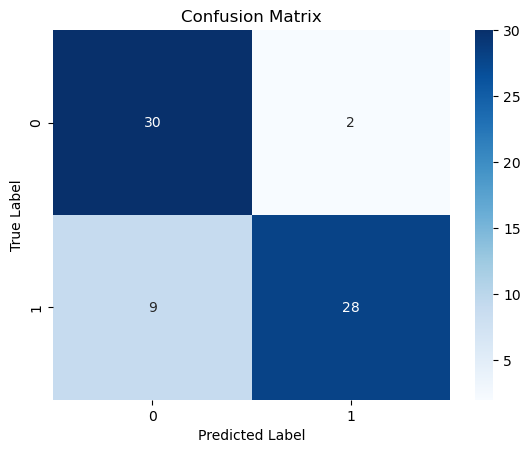

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predicted_labels = torch.cat(predicted_labels_list, dim=0).squeeze().cpu()
true_labels = torch.cat(labels_list, dim=0)

# Confusion Matrix
true_labels = true_labels.detach().numpy()
predicted_labels = predicted_labels.detach().numpy()
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [24]:
def get_gradcam(model, image, prediction, size):
    prediction.backward()    
    gradients = model.get_gradient()
    pooled_gradients = torch.mean(gradients, dim = [0, 2, 3])
    activations = model.get_activations(image).detach() # A1, A2, ..., Ak
    
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (size, size))
    
    return heatmap

In [29]:
def plot_heatmap(denorm_image, pred, heatmap):

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,20), ncols=3)

    classes = ['healthy', 'schizophrenic']
    ps = F.sigmoid(pred).cpu().detach().numpy()
    ax1.imshow(denorm_image)
    ax1.axis('off')

    ax2.barh(classes, [ps[0].item(), (1 - ps[0]).item()])
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    ax3.imshow(denorm_image)
    ax3.imshow(heatmap, cmap='magma', alpha=0.7)
    ax3.axis('off')


Using cache found in /home/rishab/.cache/torch/hub/pytorch_vision_v0.10.0
/home/rishab/miniconda3/envs/schizo/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishab/miniconda3/envs/schizo/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


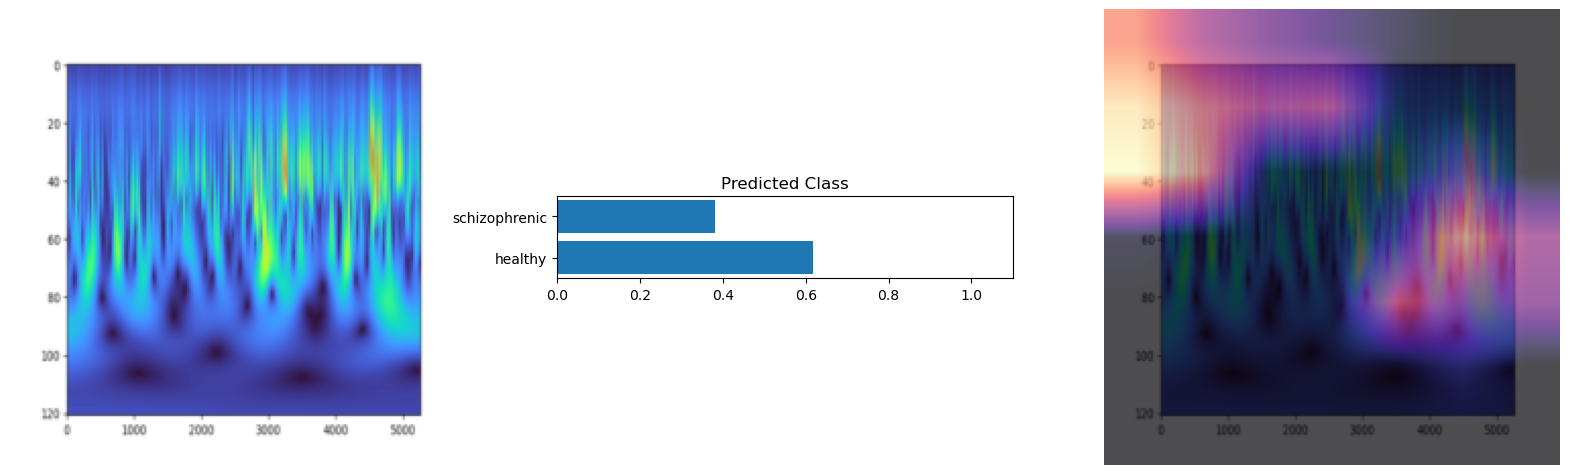

In [30]:
model = resnet(num_classes=1).to(device)
ex_number = 2
image, label = test_dataset[ex_number]
denorm_image = image.permute(1, 2, 0) * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))

image = image.unsqueeze(0).to(device)

pred = model(image)
heatmap = get_gradcam(model, image, pred, size=224)
plot_heatmap(denorm_image, pred, heatmap)